In [1]:
import signac
from cmeutils.structure import gsd_rdf
from cmeutils.dynamics import msd_from_gsd
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np
from shutil import copyfile
import os

In [26]:
from math import factorial
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """

    Parameters
    ----------
    y:
    window_size:
    order:
    deriv:
    rate:

    Returns
    -------

    """
    if not (isinstance(window_size, int) and isinstance(order, int)):
        raise ValueError("window_size and order must be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")

    order_range = range(order + 1)
    half_window = (window_size - 1) // 2
    b = np.mat(
        [
            [k ** i for i in order_range]
            for k in range(-half_window, half_window + 1)
        ]
    )
    m = np.linalg.pinv(b).A[deriv] * rate ** deriv * factorial(deriv)
    firstvals = y[0] - np.abs(y[1 : half_window + 1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window - 1 : -1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode="valid")


def moving_average_smoothing(raw_data, w):
        return np.convolve(raw_data, np.ones(w), "same")/w
    
    
color_dict = {1.0: "#0F0E0F", 0.9: "#450B0C", 0.8: "#7B0708", 0.7: "#B00405", 0.6: "#E60001"}
pair_color_dict = {("E", "E"): "#0F0E0F", ("K", "K"): "#7B0708", ("E", "K"): "#E60001",}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 2
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200

In [19]:
cg_project = signac.get_project("../coarse-grain-sims/cg-non-training-states/polybinder-flow/")
ua_project = signac.get_project("../ua-target-runs/non-training-states/polybinder-flow/")

/home/chris/cme/projects/pekk-msibi/coarse-grain-sims/cg-non-training-states/polybinder-flow/workspace/b2399e302110dfc66b9fc1f91f4e81a7


Text(0, 0.5, 'g(r)')

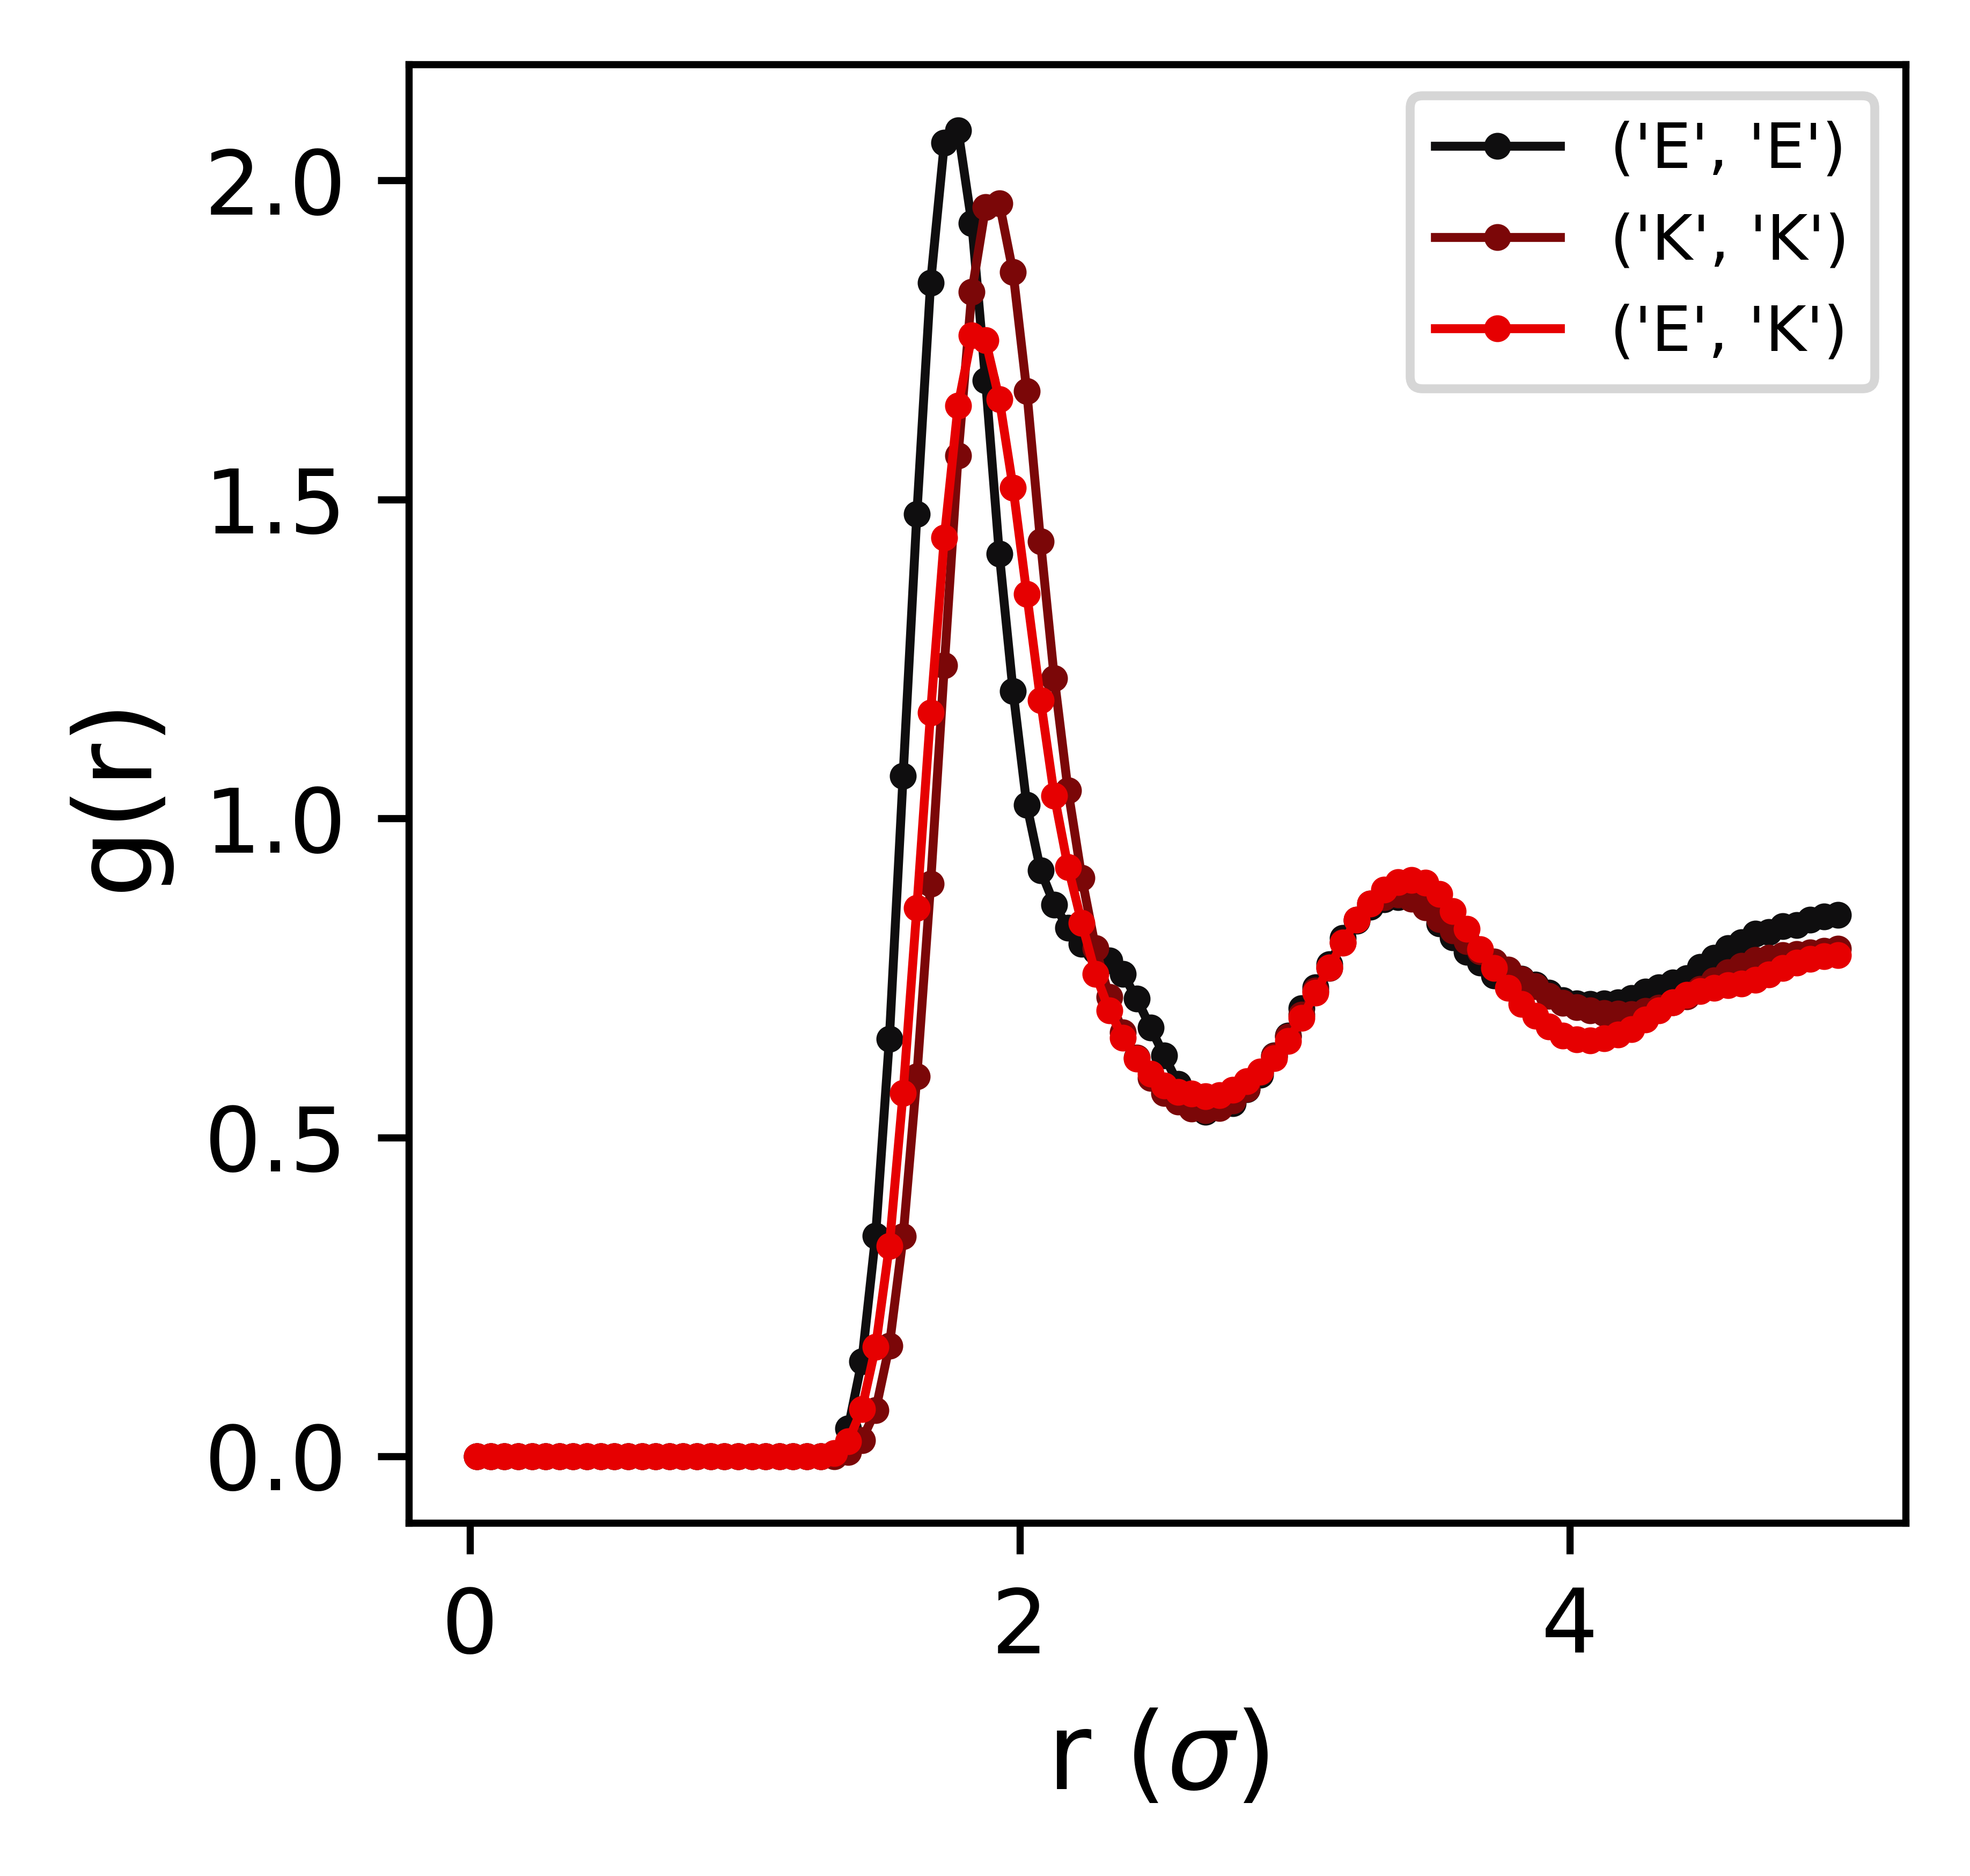

In [36]:
pairs = [
    ("E", "E"),
    ("K", "K"),
    ("E", "K"),
]
for job in cg_project.find_jobs({"kT_quench": 1.0}):
    print(job.ws)
    for pair in pairs:
        rdf, norm = gsd_rdf(
            job.fn("sim_traj.gsd"),
            start=-50,
            stop=-1,
            A_name=pair[0],
            B_name=pair[1],
            r_max=5.0,
            exclude_bonded=True
        )
        # Plot smoothed RDF
        c = pair_color_dict[pair]
        rdf_smooth = savitzky_golay(rdf.rdf*norm, window_size=9, order=2)
        where_neg = np.where(rdf_smooth < 0)
        rdf_smooth[where_neg[0]] = 0
        plt.plot(rdf.bin_centers, rdf_smooth, label=pair, c=c)
    
plt.legend()
plt.xlabel("r ($\sigma$)")
plt.ylabel("g(r)")

Text(0, 0.5, 'g(r)')

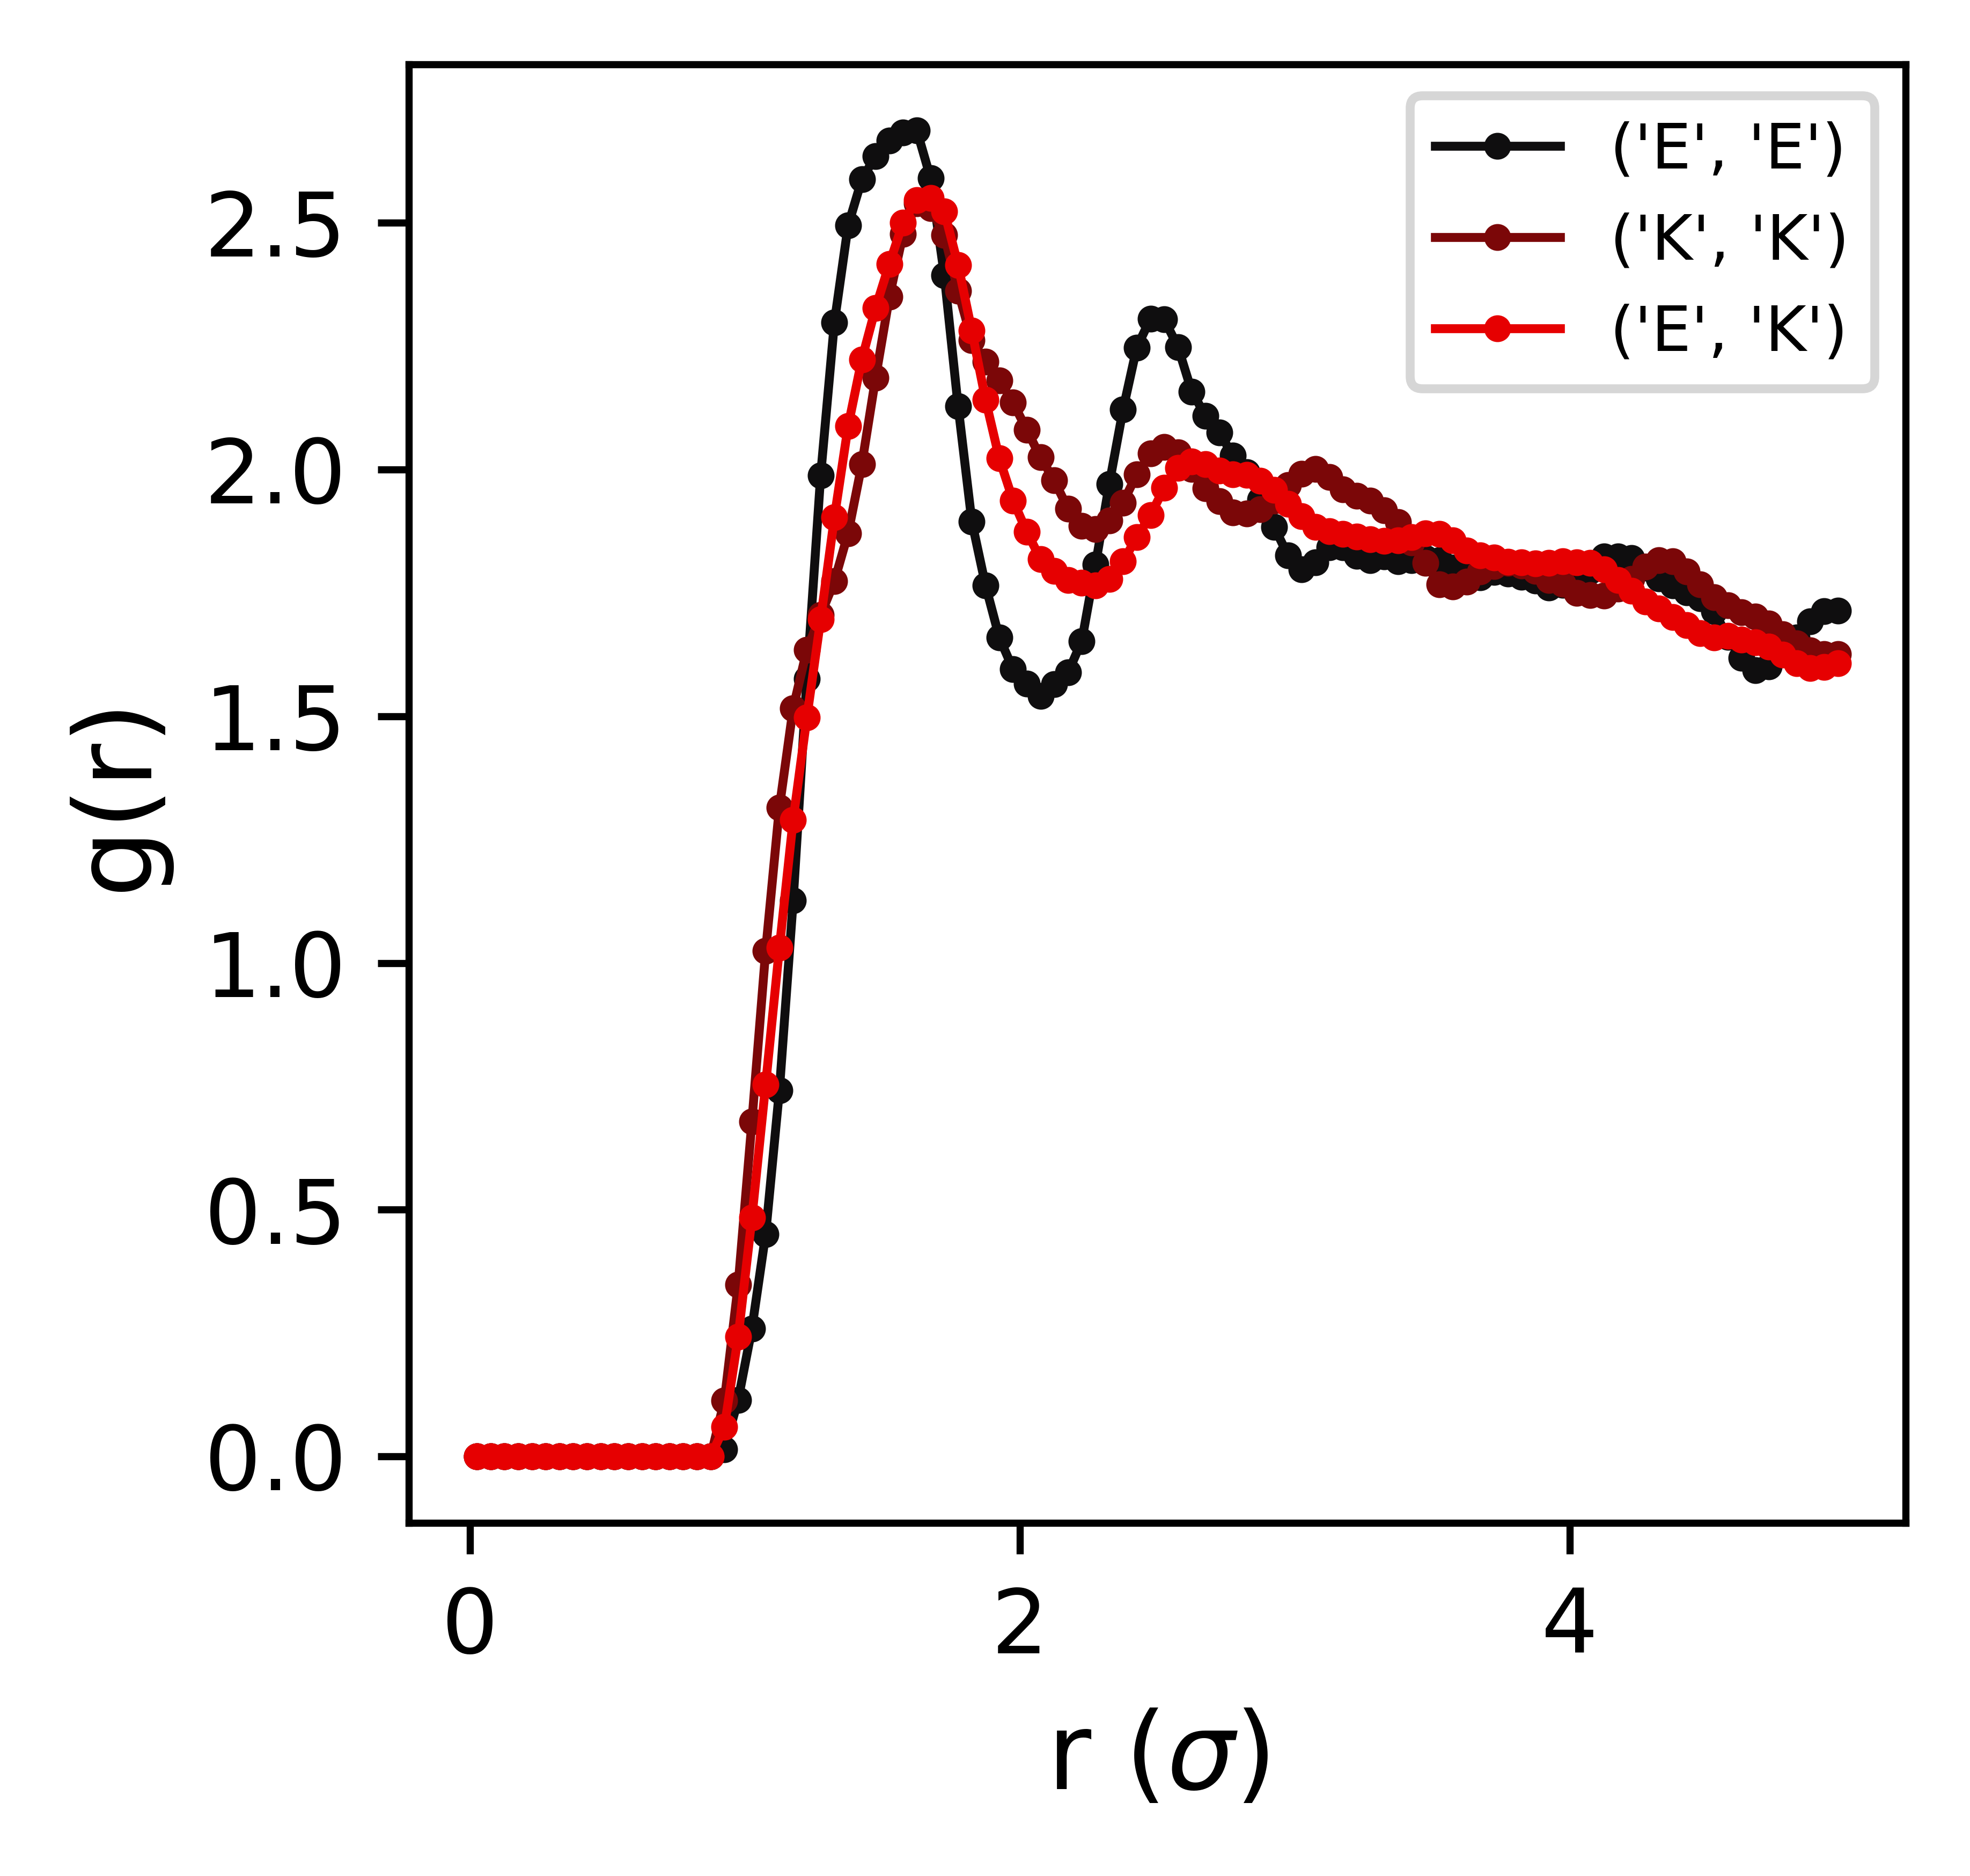

In [29]:
pairs = [
    ("E", "E"),
    ("K", "K"),
    ("E", "K"),
]
for job in ua_project.find_jobs({"kT_quench": 1.0}):
    for pair in pairs:
        rdf, norm = gsd_rdf(
            job.fn("components.gsd"),
            start=-50,
            stop=-1,
            A_name=pair[0],
            B_name=pair[1],
            r_max=5.0,
            exclude_bonded=True
        )
        c = pair_color_dict[pair]

        # Plot smoothed RDF
        rdf_smooth = savitzky_golay(rdf.rdf*norm, window_size=9, order=2)
        where_neg = np.where(rdf_smooth < 0)
        rdf_smooth[where_neg[0]] = 0
        plt.plot(rdf.bin_centers, rdf_smooth, label=pair, c=c)
    
plt.legend()
plt.xlabel("r ($\sigma$)")
plt.ylabel("g(r)")

Text(0, 0.5, 'g(r)')

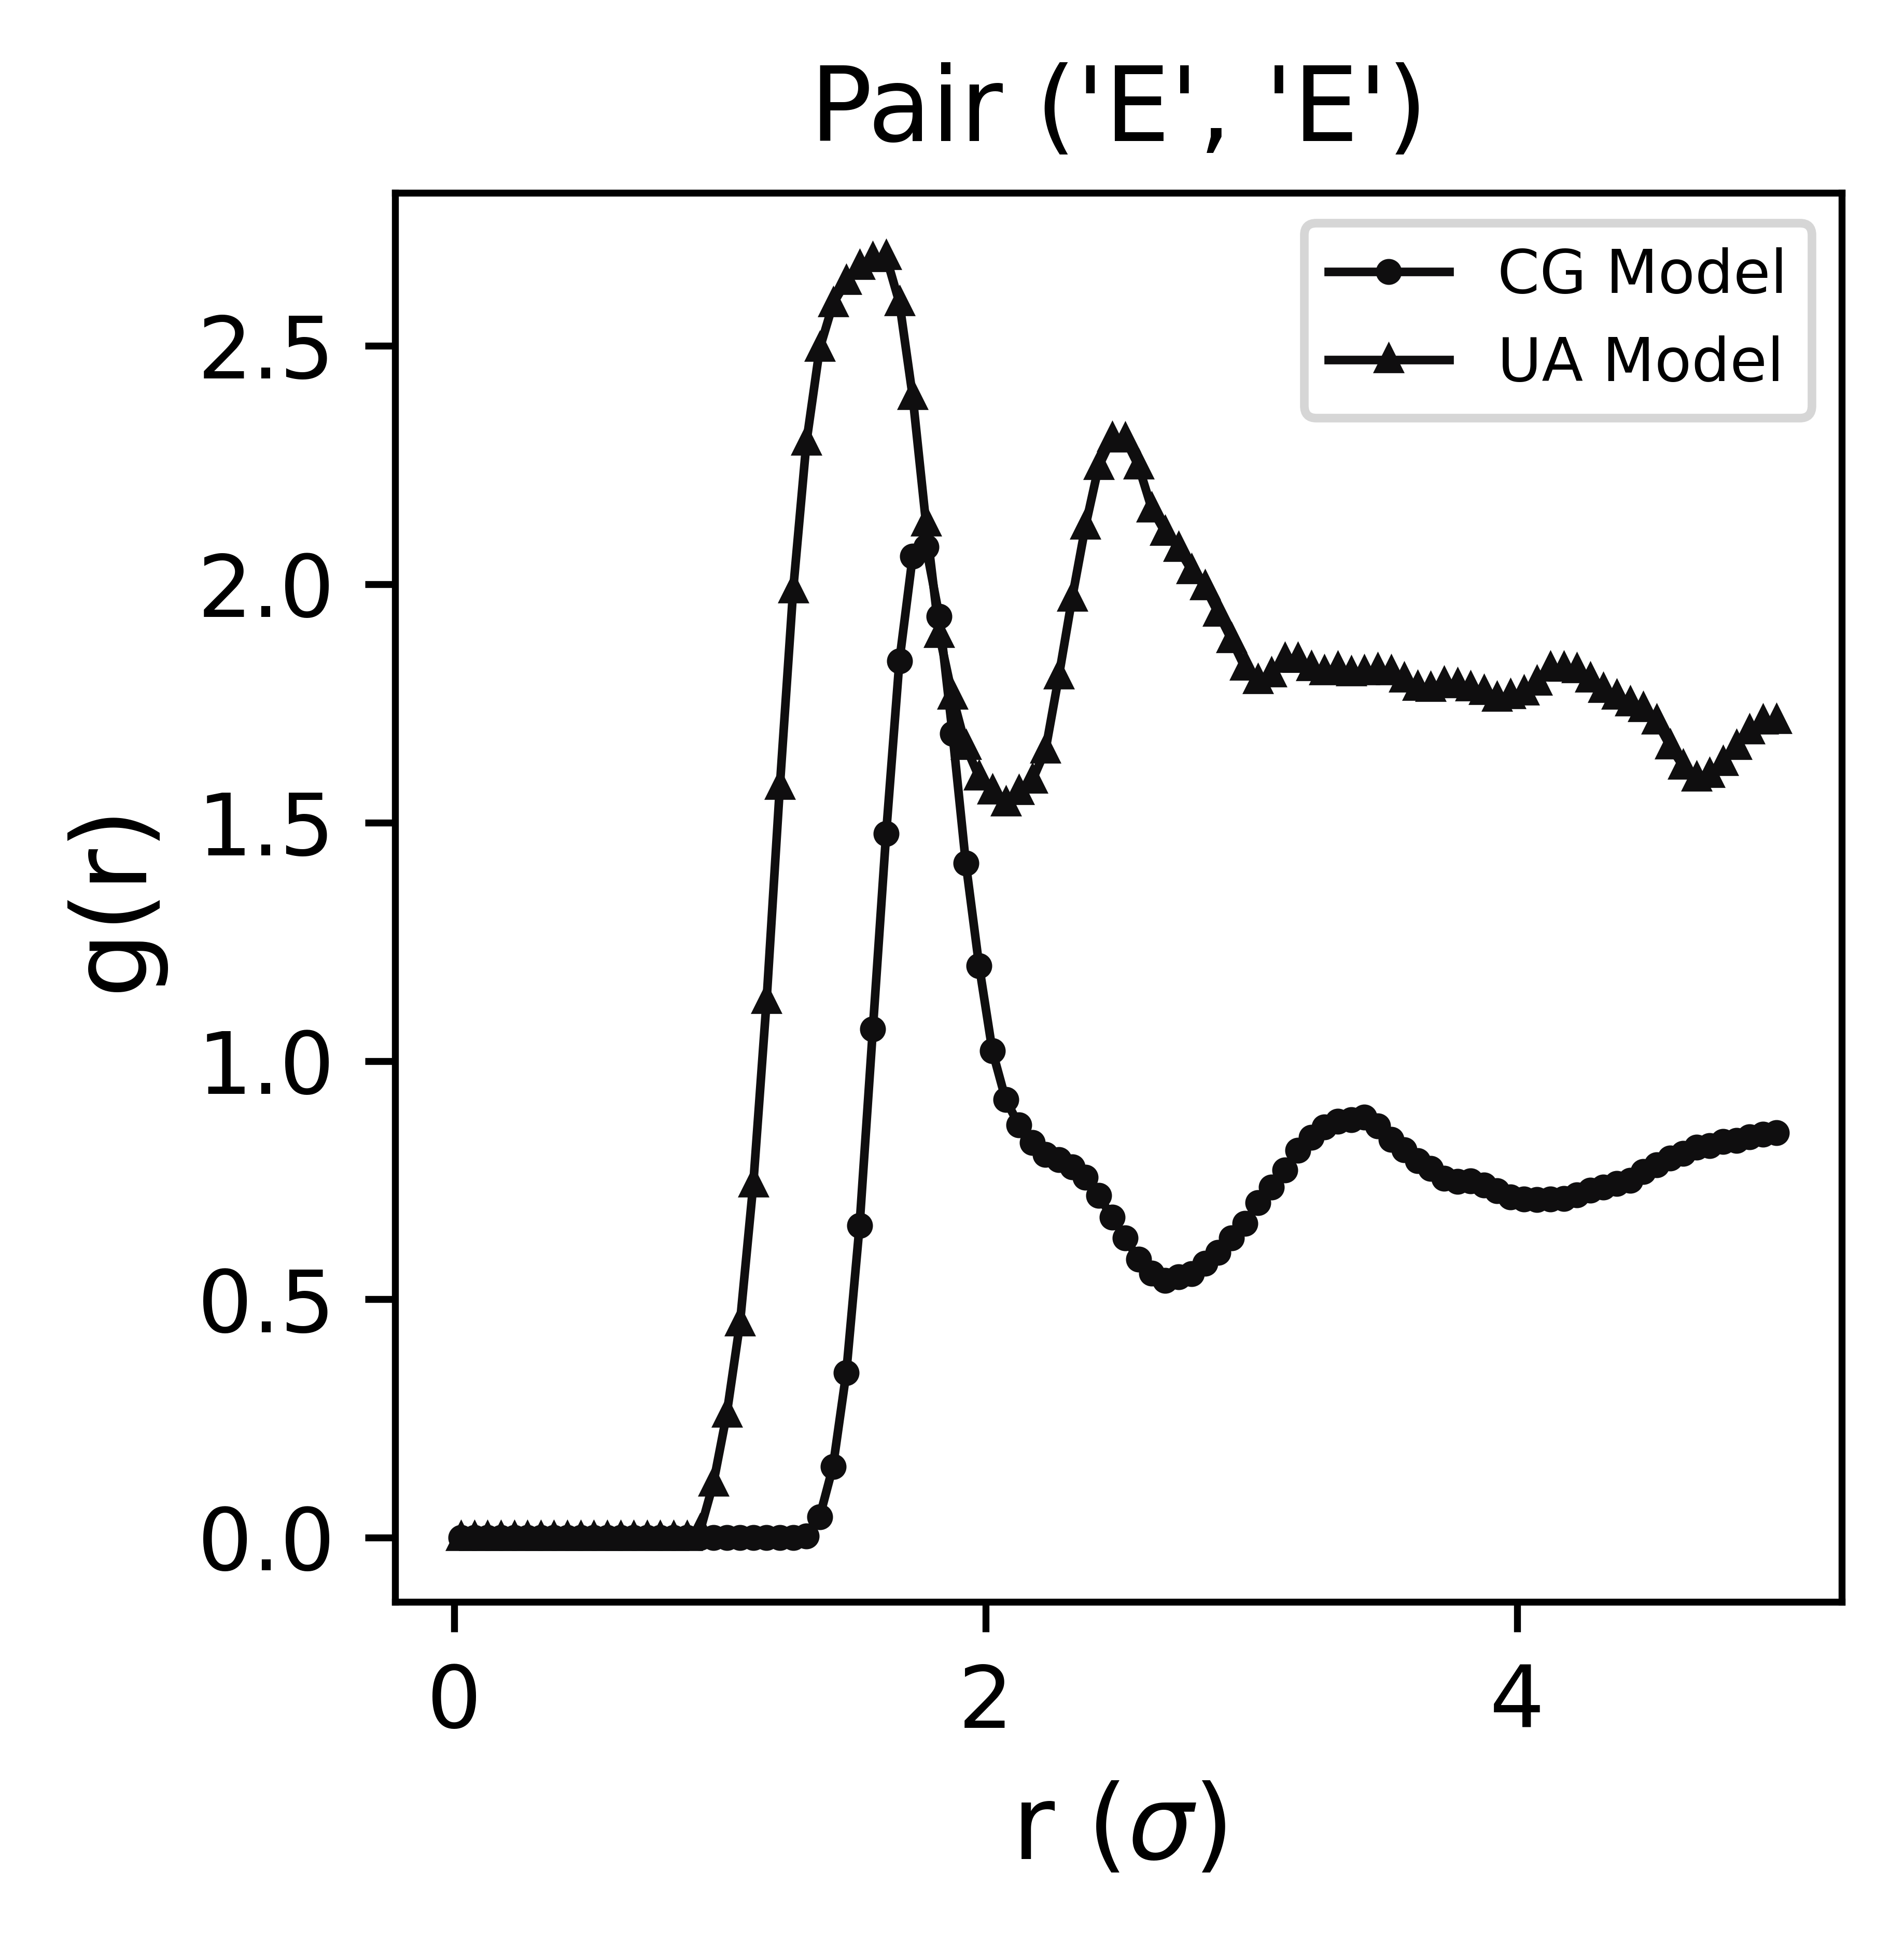

In [52]:
fig = plt.figure()
pairs = [
    ("E", "E"),
    #("K", "K"),
    #("E", "K"),
]
kT = 1.0
for job in cg_project.find_jobs({"kT_quench": kT}):
    for pair in pairs:
        rdf, norm = gsd_rdf(
            job.fn("sim_traj.gsd"),
            start=-50,
            stop=-1,
            A_name=pair[0],
            B_name=pair[1],
            r_max=5.0,
            exclude_bonded=True
        )
        c = pair_color_dict[pair]
        # Plot smoothed RDF
        rdf_smooth = savitzky_golay(rdf.rdf*norm, window_size=9, order=2)
        where_neg = np.where(rdf_smooth < 0)
        rdf_smooth[where_neg[0]] = 0
        plt.plot(rdf.bin_centers, rdf_smooth, label="CG Model", c=c)

for job in ua_project.find_jobs({"kT_quench": kT}):
    for pair in pairs:
        rdf, norm = gsd_rdf(
            job.fn("components.gsd"),
            start=-50,
            stop=-1,
            A_name=pair[0],
            B_name=pair[1],
            r_max=5.0,
            exclude_bonded=True
        )
        c = pair_color_dict[pair]
        # Plot smoothed RDF
        rdf_smooth = savitzky_golay(rdf.rdf*norm, window_size=9, order=2)
        where_neg = np.where(rdf_smooth < 0)
        rdf_smooth[where_neg[0]] = 0
        plt.plot(rdf.bin_centers, rdf_smooth, label="UA Model", marker="^", c=c)
        plt.title(f"Pair {pair}")
        
plt.legend()
plt.xlabel("r ($\sigma$)")
plt.ylabel("g(r)")